In [2]:
import pandas as pd
import numpy as np
import hics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm

1_wHiCS: 10 datasets, each 100 independent features, 40 of them useful  
2_wRaR: 10 datasets, each 30 independent features, 20 of them useful, 70 dependent features
3_wRaR: 10 datasets, each 100 independent features, 50 of them useful, 100 dependent features

In [15]:
import arff
datas = []
for i in range(1, 11):
    file = open('../data/3_wrar/3_wrar_' + str(i) + '.arff', 'r')
    dataset = arff.load(file)
    data = pd.DataFrame(dataset['data'])
    data[100] = data[100].astype(np.float32)
    data.rename(columns=lambda c: str(c), inplace=True)
    datas.append(data)
target = str(100)

In [ ]:
# Artificially imbalance dataset
class0 = data.loc[data[target] == 0]
class1 = data.loc[data[target] == 1]
imb_data = pd.concat([class1.sample(frac=0.02), class0]).reset_index(drop=True)
# For perfectly balanced dataset, this will result in a 97.56:2.44 ratio

## Ground truth

In [ ]:
# For test7.arff
weights = [0.5335601544927123, 0.759839177764759, 0.772151052808685, 0.7625265610410171,
           0.5612073314384326, 0.34594353279215817, 0.26778115186982904, 0.05104168604756121,
           0.24539066769327755, 0.4298986108981449, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ground_truth = pd.DataFrame(columns=input_features, index=[0])
ground_truth.iloc[0] = weights
# ground_truth.rename(columns=lambda c: int(c), inplace=True)
ground_truth

In [ ]:
# For test8.arff
weights = [0.5335601544927123, 0.759839177764759, 0.772151052808685, 0.7625265610410171,
           0.5612073314384326, 0.34594353279215817, 0.26778115186982904, 0.05104168604756121,
           0.24539066769327755, 0.4298986108981449, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ground_truth = pd.DataFrame(columns=data.columns[:20], index=[0])
ground_truth.iloc[0] = weights
# ground_truth.rename(columns=lambda c: int(c), inplace=True)
ground_truth

In [ ]:
# For test9.arff
weights = [0.7168886878437233, 0.1650913157879492, 0.7017219042598103, 0.5371651431980248,
           0.4012494719087343, 0.08997742462568355, 0.4133240085774441, 0.3003377473503873,
           0.12858013417222078, 0.5857996257919974, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ground_truth = pd.DataFrame(columns=data.columns[:20], index=[0])
ground_truth.iloc[0] = weights
# ground_truth.rename(columns=lambda c: int(c), inplace=True)
ground_truth

In [ ]:
# For test10.arff
weights = [0.2673055187472877, 0.196159223714542, 0.701161636883324, 0.765385125610722,
           0.0011260947105074194, 0.22801651296579062, 0.8949526553930152, 0.13072480437597472,
           0.6333889311003507, 0.7420344156127076, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
           0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
           0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
           0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ground_truth = pd.DataFrame(columns=data.columns[:70], index=[0])
ground_truth.iloc[0] = weights
# ground_truth.rename(columns=lambda c: int(c), inplace=True)
ground_truth

In [ ]:
ideal_ranking = ground_truth.sort_values(0, axis=1, ascending=False).columns

## Compensating HiCS

## Standard HiCS

## Testing classifier

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_res, y_res = rus.fit_sample(X_train, y_train)
X_res = pd.DataFrame(X_res, columns=X_train.columns)
# y_res = pd.DataFrame(y_res, columns=[20])

In [ ]:
counts/len(datas[0])

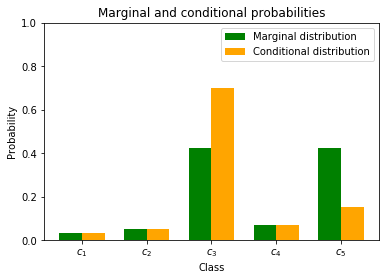

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

values, counts = np.unique(datas[0][target], return_counts=True)
marg = ax.bar(np.arange(5), counts/len(datas[0]), 0.35, color='green')
cond = ax.bar(np.arange(5) + 0.35, [0.03, 0.05, 0.7, 0.07, 0.15], 0.35, color='orange')
# ax.bar(np.arange(5), counts/len(data), 0.35, color='green')

ax.set_ylabel('Probability')
ax.set_xlabel('Class')
ax.set_title('Marginal and conditional probabilities')
ax.set_xticks(np.arange(5) + 0.35 / 2)
ax.set_xticklabels(('$c_1$', '$c_2$', '$c_3$', '$c_4$', '$c_5$'))
ax.set_ylim([0, 1])

ax.legend((marg, cond), ('Marginal distribution', 'Conditional distribution'))
plt.savefig('marg_cond')

plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
log = open('binary_wHiCS_log.txt', 'w')
for i, data in enumerate(datas):
    # Compensating HiCS
    #
    #
    values, counts = np.unique(data[target], return_counts=True)
    cost_matrix = pd.DataFrame(columns=values)
    for value, count in zip(values, counts):
        weighting = (len(data) / count)
        cost_matrix[value] = [weighting]
    cost_matrix = cost_matrix
    cost_matrix

    from hics.result_storage import DefaultResultStorage
    input_features = [ft for ft in data.columns.values if ft != target]
    storage = DefaultResultStorage(input_features)

    from hics.incremental_correlation import IncrementalCorrelation
    correlation = IncrementalCorrelation(data, target, storage,
                                         iterations=50, alpha=0.1,
                                         drop_discrete=False, cost_matrix=cost_matrix)

    correlation.update_bivariate_relevancies(runs=5)

    ranking = storage.get_relevancies().relevancy.sort_values(ascending=False)
    rank_columns = [tup[0] for tup in ranking.index.values]

    # Standard HiCS
    #
    #
    input_features = [ft for ft in data.columns.values if ft != target]
    storage_nocomp = DefaultResultStorage(input_features)
    correlation_nocomp = IncrementalCorrelation(data, target, storage_nocomp,
                                                iterations=50, alpha=0.1,
                                                drop_discrete=False, cost_matrix=None)

    correlation_nocomp.update_bivariate_relevancies(runs=5)

    ranking_nocomp = storage_nocomp.get_relevancies(
    ).relevancy.sort_values(ascending=False)
    rank_columns_nocomp = [tup[0] for tup in ranking_nocomp.index.values]

    # Train/Test split
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Test Classifier
    #
    #
    k = 10
    results_nocomp = []
    from sklearn.metrics import f1_score
    for j in range(100):
        clf = RandomForestClassifier()
        clf.fit(X_train[rank_columns_nocomp[:k]], y_train)
        y_predict_ideal = clf.predict(X_test[rank_columns_nocomp[:k]])
        results_nocomp.append(
            f1_score(y_test, y_predict_ideal, average='macro'))

    results = []
    for j in range(100):
        clf_selected = RandomForestClassifier()
        clf_selected.fit(X_train[rank_columns[:k]], y_train)
        y_predict = clf_selected.predict(X_test[rank_columns[:k]])
        results.append(f1_score(y_test, y_predict, average='macro'))
    
    print('Dataset 1_whics_' + str(i+1), file=log)
    print('Weighted RaR macro-weighted F1: ' + str(np.mean(results)), file=log)
    print('Standard RaR macro-weighted F1: ' + str(np.mean(results_nocomp)), file=log)
    print('Difference weighted-standard: ' + str(np.mean(results) - np.mean(results_nocomp)), file=log)
    log.flush()

In [61]:
import csrar
from sklearn.neighbors import KNeighborsClassifier
max_k = 30
classes = np.arange(len(np.unique(datas[0][target])))
columns = ['RaR' + str(i) for i in classes] + ['wRaR' + str(i) for i in classes]
scores = pd.DataFrame(columns=columns, index=np.arange(1,max_k+1)).fillna(0)
for data in datas:
    # Compensating RaR
    #
    #
    rar = csrar.rar.RaR(data)
    rar.run(target, k=5, runs=200, split_iterations=10, compensate_imbalance=True)

    # Standard RaR
    #
    #
    rar_nocomp = csrar.rar.RaR(data)
    rar_nocomp.run(target, k=5, runs=200, split_iterations=10, compensate_imbalance=False)

    # Train/Test split
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Test Classifier
    #
    #
    rank_columns_nocomp = [r[0] for r in rar_nocomp.feature_ranking]
    from sklearn.metrics import f1_score
    for k in range(1, max_k+1):
        clf = KNeighborsClassifier(n_neighbors=5)
        clf.fit(X_train[rank_columns_nocomp[:k]], y_train)
        y_predict_ideal = clf.predict(X_test[rank_columns_nocomp[:k]])
        score = f1_score(y_test, y_predict_ideal, average=None)
        for i, s in enumerate(score):
            scores.loc[k, 'RaR' + str(i)] += s
        
    rank_columns = [r[0] for r in rar.feature_ranking]
    for k in range(1, max_k+1):
        clf_selected = KNeighborsClassifier(n_neighbors=5)
        clf_selected.fit(X_train[rank_columns[:k]], y_train)
        y_predict = clf_selected.predict(X_test[rank_columns[:k]])
        score = f1_score(y_test, y_predict, average=None)
        for i, s in enumerate(score):
            scores.loc[k, 'wRaR' + str(i)] += s

scores /= len(datas)
scores.to_csv('final_wRaR_2wrar_5nn_noavg.csv')
scores

Generated cost matrix:
         0.0   1.0       2.0        3.0       4.0
0  33.112583  20.0  2.352941  14.285714  2.354049
Overall cost matrix:
         0.0   1.0       2.0        3.0       4.0
0  33.112583  20.0  2.352941  14.285714  2.354049
Relevance: 100.00%    
Running optimizer...
Optimizer done.
{'75': 1.5546670828535795e-09, '89': 1.5554649891571716e-09, '48': 0.01663337697603145, '44': 1.5558459816357282e-09, '79': 0.19830818517701618, '10': 1.5567578518816186e-09, '25': 0.18242400310224013, '54': 0.6795708000450678, '92': 4.357054204554617e-07, '45': 0.1850623676431955, '46': 0.014675921206038842, '67': 1.5548028177234013e-09, '74': 0.6533028219751995, '15': 0.22912288967869768, '82': 0.21112535600542226, '18': 0.13705029573706903, '47': 0.13561110116001776, '69': 0.5858730135533287, '71': 0.28959367537092867, '95': 0.24857368847322145, '19': 0.009256133035718178, '0': 1.578193755509194e-09, '49': 0.09591482899517138, '98': 1.5556563943132153e-09, '52': 3.0740633053767623e-09

Redundancy: 100.00%    
1. 76 with a score of 0.9976042742153748
2. 14 with a score of 0.769677094710173
3. 15 with a score of 0.6313353923522711
4. 39 with a score of 0.5944005490092699
5. 69 with a score of 0.5915098925602823
6. 6 with a score of 0.5565984080500245
7. 7 with a score of 0.5272862494510838
8. 37 with a score of 0.42681526983523066
9. 78 with a score of 0.42653740233161574
10. 0 with a score of 0.42021066782904504
11. 96 with a score of 0.40814429284764364
12. 5 with a score of 0.3645347830305863
13. 98 with a score of 0.3101360273726596
14. 54 with a score of 0.3101331146255246
15. 8 with a score of 0.2941109503172976
16. 52 with a score of 0.29398526103498
17. 57 with a score of 0.2543823870565709
18. 55 with a score of 0.2491041315902895
19. 77 with a score of 0.24167687923172934
20. 72 with a score of 0.2324147786327838
21. 68 with a score of 0.2099893276738913
22. 49 with a score of 0.20754335344189925
23. 12 with a score of 0.19631293308378758
24. 41 with a score 

Relevance: 100.00%    
Running optimizer...
Optimizer done.
{'75': 0.12441327917572112, '89': 1.140237711061868e-11, '48': 0.20214222934906323, '44': 0.07181311170674742, '79': 0.16058762547690952, '10': 0.07442482890271648, '25': 0.05895393685928212, '54': 0.05889469666298716, '92': 0.012967557201414018, '45': 1.1396721979628833e-11, '46': 0.09053327116444744, '67': 0.3007106632154031, '74': 0.522991022573222, '15': 0.07512499603200128, '82': 0.06244568614998961, '18': 0.1417513541126779, '47': 1.0, '69': 0.07360458043846377, '71': 0.023714236156013365, '95': 0.020738533083698298, '19': 0.4492435381053322, '0': 1.1400596541166449e-11, '49': 0.02610306614986488, '98': 0.17858445223717437, '52': 0.14982939959014763, '72': 1.1259356261883135e-11, '1': 1.1364404361368418e-11, '83': 0.0796517267280995, '29': 0.10444879215904491, '39': 0.09492867992578188, '22': 0.05387793268460245, '28': 0.08305674327475304, '53': 0.0718131711004816, '3': 0.09436658639236228, '91': 0.03690255326511016, '88

Redundancy: 100.00%    
1. 61 with a score of 0.9966991401711631
2. 40 with a score of 0.745422450939204
3. 0 with a score of 0.7366520966332901
4. 67 with a score of 0.5356753856018608
5. 48 with a score of 0.44371615859356944
6. 59 with a score of 0.41071060172558027
7. 13 with a score of 0.40084043552021115
8. 85 with a score of 0.3452392465856246
9. 16 with a score of 0.34362467748511577
10. 80 with a score of 0.3394625334760492
11. 97 with a score of 0.33921323646426876
12. 94 with a score of 0.3315818684204481
13. 4 with a score of 0.33134813419389686
14. 82 with a score of 0.33122528193041473
15. 69 with a score of 0.3207696159407723
16. 5 with a score of 0.29481578498807964
17. 49 with a score of 0.28957346288628966
18. 65 with a score of 0.25755803856144865
19. 63 with a score of 0.25213600504212097
20. 31 with a score of 0.2469242509087738
21. 50 with a score of 0.23065717641545766
22. 30 with a score of 0.22813090127550922
23. 45 with a score of 0.22811394695904988
24. 9 wit

Generated cost matrix:
         0.0   1.0       2.0        3.0       4.0
0  33.112583  20.0  2.352941  14.285714  2.354049
Overall cost matrix:
         0.0   1.0       2.0        3.0       4.0
0  33.112583  20.0  2.352941  14.285714  2.354049
Relevance: 100.00%    
Running optimizer...
Optimizer done.
{'75': 0.31868397750011074, '89': 4.0265255003525965e-10, '48': 0.14436014268870165, '44': 0.30274303863603585, '79': 0.18169641429434025, '10': 0.13381451031815347, '25': 4.026437034014042e-10, '54': 0.30760317191037695, '92': 4.026458388145043e-10, '45': 0.2818436895900576, '46': 0.1371489275839069, '67': 0.06741329498877009, '74': 0.12197271298631421, '15': 0.807387807270461, '82': 0.2473068596435519, '18': 0.42092911608430295, '47': 0.5166174551805093, '69': 0.21395221152767693, '71': 4.026461753745106e-10, '95': 0.20480737811641475, '19': 4.026412976242455e-10, '0': 0.5961681215617607, '49': 0.14733399217076348, '98': 4.015016315654001e-10, '52': 0.13710393364486773, '72': 0.1013714

Redundancy: 100.00%    
1. 18 with a score of 0.9980662678970413
2. 38 with a score of 0.9764709736561052
3. 30 with a score of 0.7524106257536768
4. 11 with a score of 0.7250413066739734
5. 63 with a score of 0.6904703391133098
6. 3 with a score of 0.6151601270355358
7. 59 with a score of 0.6149963269395834
8. 54 with a score of 0.5690172436425959
9. 49 with a score of 0.5189297636394616
10. 0 with a score of 0.5053602221586794
11. 8 with a score of 0.4876747364978511
12. 12 with a score of 0.4323899453517076
13. 33 with a score of 0.4175901788108465
14. 80 with a score of 0.39501975400949674
15. 79 with a score of 0.32478855538564305
16. 61 with a score of 0.2951928090897348
17. 58 with a score of 0.28358833178682596
18. 84 with a score of 0.2809190689572459
19. 66 with a score of 0.2788581951724356
20. 32 with a score of 0.27737311414960986
21. 90 with a score of 0.2656536994730063
22. 39 with a score of 0.2648177372000648
23. 78 with a score of 0.25182466513382507
24. 5 with a scor

Relevance: 100.00%    
Running optimizer...
Optimizer done.
{'75': 6.255612811738744e-10, '89': 0.19464069588587046, '48': 3.1969151771389496e-08, '44': 0.30159850909453967, '79': 4.5549800446479645e-10, '10': 0.12657757051240692, '25': 0.03702755781824772, '54': 0.08591598895416205, '92': 4.5517559882721544e-10, '45': 0.14140255297983362, '46': 0.5703734717454924, '67': 0.45103417763331344, '74': 0.12158528625723794, '15': 0.9473491659283884, '82': 4.2714197312601053e-10, '18': 5.224250850195373e-10, '47': 4.539891269526062e-10, '69': 0.2688569590368187, '71': 0.08009764412707202, '95': 0.2635711530341845, '19': 0.5317718434949678, '0': 0.4883734817626147, '49': 8.265568051188131e-10, '98': 4.467735530043309e-10, '52': 0.5375991715835748, '72': 0.16829055063312678, '1': 0.09120074641638973, '83': 1.0059731520843622e-07, '29': 0.14704179854635566, '39': 0.14028587562929, '22': 0.12306605227095845, '28': 0.14176066628489487, '53': 0.19464043559946617, '3': 0.19573738472444482, '91': 0.9

Redundancy: 100.00%    
1. 31 with a score of 0.997001033088936
2. 14 with a score of 0.9538242080358919
3. 18 with a score of 0.8197182671933712
4. 47 with a score of 0.6791177342773713
5. 10 with a score of 0.5795309172880394
6. 85 with a score of 0.5737199437765348
7. 51 with a score of 0.569309997416094
8. 3 with a score of 0.569280505165679
9. 66 with a score of 0.5118250262331953
10. 91 with a score of 0.49383880531010776
11. 5 with a score of 0.4713721135621897
12. 1 with a score of 0.4713453834808333
13. 63 with a score of 0.47117472714336345
14. 9 with a score of 0.4446246730274991
15. 12 with a score of 0.4068320627759498
16. 69 with a score of 0.38045597265682357
17. 42 with a score of 0.3744477462079103
18. 50 with a score of 0.3413212874158817
19. 8 with a score of 0.3369382047214154
20. 7 with a score of 0.33073388134144976
21. 98 with a score of 0.304032377536953
22. 40 with a score of 0.30196209436069554
23. 36 with a score of 0.30034444069136856
24. 19 with a score of 

Generated cost matrix:
         0.0   1.0       2.0        3.0       4.0
0  33.112583  20.0  2.352941  14.285714  2.354049
Overall cost matrix:
         0.0   1.0       2.0        3.0       4.0
0  33.112583  20.0  2.352941  14.285714  2.354049
Relevance: 100.00%    
Running optimizer...
Optimizer done.
{'75': 0.032825260063539564, '89': 0.10327300346023552, '48': 0.001110888421418361, '44': 1.860305565363572e-10, '79': 0.060449700058384126, '10': 0.3127406196361171, '25': 0.11383638780284827, '54': 0.07288054880995636, '92': 3.991340857495428e-10, '45': 0.08383294095233103, '46': 0.026178167047315615, '67': 0.17316328725608213, '74': 4.608724633773386e-10, '15': 0.15148858111123958, '82': 3.648905971141937e-10, '18': 0.11506299773768303, '47': 3.8490833063657977e-10, '69': 3.5946778819958156e-10, '71': 0.041427150388715146, '95': 4.0311639299872074e-10, '19': 0.007816782221900295, '0': 1.8127948571893635e-10, '49': 0.0627048905300237, '98': 0.05253749030432009, '52': 0.1160134874968284

Redundancy: 100.00%    
1. 36 with a score of 0.9976545115570434
2. 6 with a score of 0.48781649051455217
3. 14 with a score of 0.43785320205851636
4. 85 with a score of 0.4096863233652405
5. 83 with a score of 0.40701972438288403
6. 50 with a score of 0.3886042640995524
7. 47 with a score of 0.3528357400221378
8. 87 with a score of 0.3425548044272657
9. 55 with a score of 0.33414989303669856
10. 15 with a score of 0.2939800544921175
11. 18 with a score of 0.2897589903391141
12. 17 with a score of 0.27758582487082295
13. 10 with a score of 0.24536142436552424
14. 68 with a score of 0.2310284162238586
15. 22 with a score of 0.2148823584307122
16. 67 with a score of 0.2145882918155598
17. 73 with a score of 0.2145630951609113
18. 91 with a score of 0.20950728109433486
19. 3 with a score of 0.19380667786465666
20. 34 with a score of 0.18283117623619582
21. 99 with a score of 0.18080787202155352
22. 54 with a score of 0.17176062674104348
23. 27 with a score of 0.15527925206854998
24. 39 wi

Relevance: 100.00%    
Running optimizer...
Optimizer done.
{'75': 0.03914416152148402, '89': 0.08334506269492395, '48': 0.07599899009690715, '44': 0.10206682429175011, '79': 0.06248681731744635, '10': 0.3014318916832992, '25': 0.04298272117247694, '54': 0.026156535333402463, '92': 0.08375627148908113, '45': 0.048373171479202136, '46': 0.04689740086693623, '67': 0.22859310011603068, '74': 0.11379258744067465, '15': 0.49669767415076455, '82': 4.327442319567179e-12, '18': 0.09711728771469563, '47': 0.16665058436872138, '69': 2.1812624057510965e-12, '71': 0.055387742064731134, '95': 0.17464165576073262, '19': 0.06353704558283679, '0': 0.31460801872534444, '49': 0.3176485374375426, '98': 1.9892207030656124e-12, '52': 0.06523096598236837, '72': 0.016966299040981382, '1': 0.037639461050147975, '83': 0.1701837763589709, '29': 4.01250156784193e-12, '39': 0.10474979228425091, '22': 0.0003591190900204483, '28': 1.9898809667553957e-12, '53': 0.17966982331579304, '3': 0.14245084837572275, '91': 0.

Redundancy: 100.00%    
1. 50 with a score of 0.9971619683704885
2. 42 with a score of 0.7765504822809478
3. 10 with a score of 0.7680378632886957
4. 86 with a score of 0.672624236045699
5. 8 with a score of 0.6501681447775616
6. 39 with a score of 0.6406450944111107
7. 3 with a score of 0.6391310827363775
8. 74 with a score of 0.631056489029499
9. 96 with a score of 0.6180123459183615
10. 58 with a score of 0.614117921013502
11. 73 with a score of 0.5938089271862521
12. 61 with a score of 0.5808727621669701
13. 68 with a score of 0.5800750814779669
14. 77 with a score of 0.5765859325756709
15. 2 with a score of 0.5303057287806446
16. 47 with a score of 0.5156530019085338
17. 81 with a score of 0.5119703763997592
18. 85 with a score of 0.49827609337955525
19. 63 with a score of 0.47730643902740666
20. 1 with a score of 0.472235831413976
21. 0 with a score of 0.4667495099627371
22. 54 with a score of 0.45973173215870955
23. 18 with a score of 0.4213100842515087
24. 36 with a score of 0.

Generated cost matrix:
         0.0   1.0       2.0        3.0       4.0
0  33.112583  20.0  2.352941  14.285714  2.354049
Overall cost matrix:
         0.0   1.0       2.0        3.0       4.0
0  33.112583  20.0  2.352941  14.285714  2.354049
Relevance: 100.00%    
Running optimizer...
Optimizer done.
{'75': 0.39205648761111295, '89': 0.08548126268091313, '48': 0.11176049693059452, '44': 0.3038106362846753, '79': 0.14485168191234538, '10': 0.5742113519220107, '25': 0.08646585619996483, '54': 0.10970410224667099, '92': 0.05128347562033686, '45': 1.111451261549791e-09, '46': 0.1317583089768919, '67': 1.0, '74': 1.1116649828779083e-09, '15': 1.7490981399752453e-07, '82': 1.109614548285972e-09, '18': 0.1560692596143891, '47': 0.2044431043216716, '69': 0.7803040105664837, '71': 0.011568926476425727, '95': 1.1112284979967717e-09, '19': 0.4457152306882777, '0': 0.21543678770675315, '49': 0.1275975935704496, '98': 0.30318192804299154, '52': 0.01156491822141741, '72': 1.1111665432430794e-09, '

Redundancy: 100.00%    
1. 10 with a score of 0.9978754960516294
2. 68 with a score of 0.9944190009096309
3. 77 with a score of 0.9906582781663809
4. 32 with a score of 0.8959833005782998
5. 65 with a score of 0.7951754815344941
6. 67 with a score of 0.7516086118436753
7. 43 with a score of 0.751482778338697
8. 5 with a score of 0.711334804342914
9. 61 with a score of 0.7091732748514035
10. 50 with a score of 0.7085497010718899
11. 3 with a score of 0.6954090802164032
12. 34 with a score of 0.6520966318695887
13. 17 with a score of 0.5692764962774104
14. 75 with a score of 0.5278930598984651
15. 90 with a score of 0.49439368811748113
16. 45 with a score of 0.433014005633794
17. 44 with a score of 0.4047118763263478
18. 99 with a score of 0.39395653600038216
19. 18 with a score of 0.3837515425795748
20. 33 with a score of 0.3697964093689469
21. 76 with a score of 0.36968174591930264
22. 46 with a score of 0.36701255837199714
23. 39 with a score of 0.363200682691392
24. 83 with a score o

,RaR0,RaR1,RaR2,RaR3,RaR4,wRaR0,wRaR1,wRaR2,wRaR3,wRaR4
1,0.100444,0.048446,0.531071,0.035604,0.527736,0.090407,0.055697,0.517081,0.035469,0.514848
2,0.153029,0.066275,0.550255,0.018036,0.575822,0.110319,0.069456,0.544944,0.033924,0.558602
3,0.198068,0.082832,0.577227,0.037340,0.616516,0.138342,0.103250,0.556734,0.029403,0.591873
4,0.210492,0.082282,0.599045,0.042501,0.645432,0.187263,0.098187,0.587085,0.041450,0.611347
5,0.224476,0.114757,0.613644,0.066345,0.660379,0.178276,0.130746,0.593717,0.040692,0.623563
6,0.227041,0.083574,0.628249,0.051694,0.675887,0.166700,0.091278,0.594763,0.035789,0.636938
7,0.214720,0.094062,0.635980,0.042986,0.672824,0.215384,0.112335,0.609861,0.032078,0.653982
8,0.256966,0.109254,0.646728,0.040829,0.691500,0.175543,0.107884,0.626435,0.046348,0.665150
9,0.179383,0.130310,0.634256,0.047908,0.679841,0.197287,0.123481,0.624589,0.053202,0.673592
10,0.197803,0.126451,0.640811,0.056065,0.688799,0.185734,0.115657,0.639181,0.044249,0.683759


In [62]:
scores

,RaR0,RaR1,RaR2,RaR3,RaR4,wRaR0,wRaR1,wRaR2,wRaR3,wRaR4
1,0.100444,0.048446,0.531071,0.035604,0.527736,0.090407,0.055697,0.517081,0.035469,0.514848
2,0.153029,0.066275,0.550255,0.018036,0.575822,0.110319,0.069456,0.544944,0.033924,0.558602
3,0.198068,0.082832,0.577227,0.037340,0.616516,0.138342,0.103250,0.556734,0.029403,0.591873
4,0.210492,0.082282,0.599045,0.042501,0.645432,0.187263,0.098187,0.587085,0.041450,0.611347
5,0.224476,0.114757,0.613644,0.066345,0.660379,0.178276,0.130746,0.593717,0.040692,0.623563
6,0.227041,0.083574,0.628249,0.051694,0.675887,0.166700,0.091278,0.594763,0.035789,0.636938
7,0.214720,0.094062,0.635980,0.042986,0.672824,0.215384,0.112335,0.609861,0.032078,0.653982
8,0.256966,0.109254,0.646728,0.040829,0.691500,0.175543,0.107884,0.626435,0.046348,0.665150
9,0.179383,0.130310,0.634256,0.047908,0.679841,0.197287,0.123481,0.624589,0.053202,0.673592
10,0.197803,0.126451,0.640811,0.056065,0.688799,0.185734,0.115657,0.639181,0.044249,0.683759


In [54]:
for data in datas:
    values, counts = np.unique(data[target], return_counts=True)
    print(counts/len(data))

[ 0.0302  0.05    0.425   0.07    0.4248]
[ 0.0302  0.05    0.425   0.07    0.4248]
[ 0.0302  0.05    0.425   0.07    0.4248]
[ 0.0302  0.05    0.425   0.07    0.4248]
[ 0.0302  0.05    0.425   0.07    0.4248]
[ 0.0302  0.05    0.425   0.07    0.4248]
[ 0.0302  0.05    0.425   0.07    0.4248]
[ 0.0302  0.05    0.425   0.07    0.4248]
[ 0.0302  0.05    0.425   0.07    0.4248]
[ 0.0302  0.05    0.425   0.07    0.4248]


In [77]:
columns[5:]

['wRaR0', 'wRaR1', 'wRaR2', 'wRaR3', 'wRaR4']

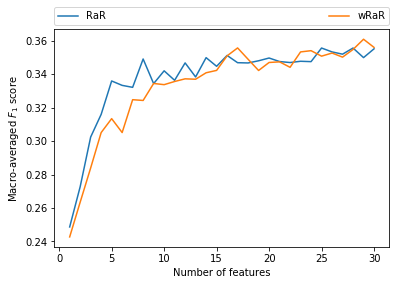

In [78]:
import matplotlib.pyplot as plt
plt.plot(np.mean(scores[columns[:5]], axis=1)[:30], label='RaR')
plt.plot(np.mean(scores[columns[5:]], axis=1)[:30], label='wRaR')
ax = plt.gca()
ax.set_xlabel('Number of features')
ax.set_ylabel(r'Macro-averaged $F_1$ score')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
# plt.savefig('final_wRaR_2wrar_1nn_best30')
plt.show()

In [ ]:
k = 15
results_nocomp = []
rank_columns_nocomp = [r[0] for r in rar_nocomp.feature_ranking]
from sklearn.metrics import f1_score
for j in range(25):
    clf = RandomForestClassifier()
    clf.fit(X_train[rank_columns_nocomp[:k]], y_train)
    y_predict_ideal = clf.predict(X_test[rank_columns_nocomp[:k]])
    results_nocomp.append(f1_score(y_test, y_predict_ideal, average='macro'))

results = []
rank_columns = [r[0] for r in rar.feature_ranking]
for j in range(25):
    clf_selected = RandomForestClassifier()
    clf_selected.fit(X_train[rank_columns[:k]], y_train)
    y_predict = clf_selected.predict(X_test[rank_columns[:k]])
    results.append(f1_score(y_test, y_predict, average='macro'))

print('Dataset 1_whics_' + str(i+1))#, file=log)
print('Weighted RaR macro-weighted F1: ' + str(np.mean(results)))#, file=log)
print('Standard RaR macro-weighted F1: ' + str(np.mean(results_nocomp)))#, file=log)
print('Difference weighted-standard: ' + str(np.mean(results) - np.mean(results_nocomp)))#, file=log)

## Cumulative Gain

In [ ]:
ideal_CG = [ground_truth.loc[0, ideal_ranking[:i].values].sum()
            for i in range(len(ideal_ranking))]
CG = [ground_truth.loc[0, [r for r in rank_columns[:i]]].sum()
      for i in range(len(rank_columns))]
nocomp_CG = [ground_truth.loc[0, [r for r in rank_columns_nocomp[:i]]].sum()
             for i in range(len(rank_columns_nocomp))]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(CG, label='Cumulative Gain Compensating HiCS')
plt.plot(nocomp_CG, label='Cumulative Gain Standard HiCS')
plt.plot(ideal_CG, label='Ideal gain')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
# plt.savefig('HiCS_test7_comp_imb2_CG_weightmod1-8')
plt.show()

## Rankings

In [ ]:
rank_columns_nocomp

In [ ]:
rank_columns

In [ ]:
ideal_ranking